In [ ]:
# default_exp interpret

In [ ]:
# hide
import sys

sys.path.append("..")

# Interpret

> Interpret the results of a model

In [ ]:
# export
from fastseq.all import *
from fastseq.data.external import *
from fastai2.basics import *
from fastseq.models.nbeats import *

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Need to pad 100/100 time series due to length.
Train:100; Valid: 600; Test 100


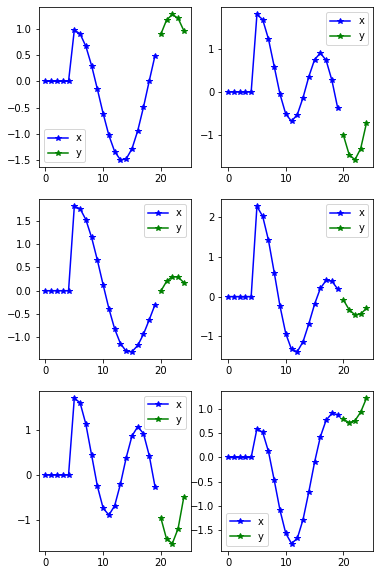

In [ ]:
items = dummy_data_generator(25,10, nrows=100)
dbunch = TSDataBunch.from_items(items, horizon = 5)
dbunch.show_batch(max_n=6)

In [ ]:
learn = nbeats_learner(dbunch)
print(learn.summary())

NBeatsNet (Input shape: ['64 x 1 x 20'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 20              40         True      
________________________________________________________________
Linear               64 x 200             4,000      True      
________________________________________________________________
ReLU                 64 x 200             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
BatchNorm1d          64 x 100             200        True      
________________________________________________________________
Linear               64 x 4               400        True      
_________________________________________________________

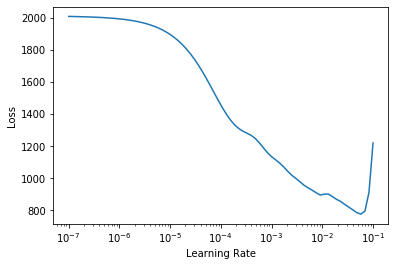

In [ ]:
learn.lr_find()

In [ ]:
learn.fit(15, .1)

epoch,train_loss,valid_loss,mae,smape,time
0,2006.630981,244326512.000000,11318.857422,93052.312500,00:00
1,119898.703125,1946969472.000000,30740.820312,93104.156250,00:00
2,358271.156250,19734842.000000,3540.307617,93080.140625,00:00
3,269676.187500,5092394.000000,1737.447144,93048.242188,00:00
4,222474.281250,1248583.625000,766.754456,92536.070312,00:00
5,194499.546875,180714.218750,294.325897,90918.531250,00:00
6,169428.515625,50645.808594,204.853195,92493.875000,00:00
7,148202.578125,166703.968750,339.462982,92744.679688,00:00
8,133889.718750,150834.656250,314.614075,92686.109375,00:00
9,122451.382812,59701.746094,208.853149,92545.164062,00:00


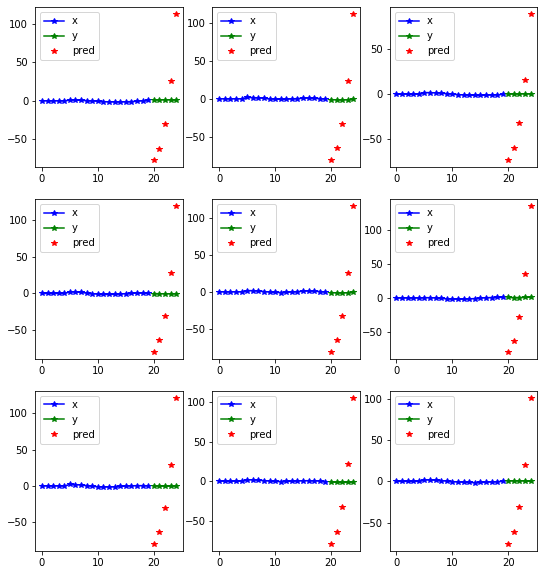

In [ ]:
learn.show_results(max_n=9)

In [ ]:
learn.get_preds(dl=learn.dbunch.dls[1], with_input=True, with_loss=True, with_decoded=True, act=None)

In [ ]:
l_dct = learn.n_beats_trainer.out
idx = [90,180]
dct = {} 
i = 0
for l in l_dct:
    for block_name, block in l.items(): 
        for k,item in block.items():
            print(block_name,k,item)
            break

trend0 b tensor([[-9.5205e+03, -8.0997e+03, -6.8276e+03,  ..., -8.6188e+00,
          1.1986e+00,  2.0051e+00],
        [-9.2140e+03, -7.8384e+03, -6.6069e+03,  ..., -8.2019e+00,
          1.2107e+00,  1.9500e+00],
        [-8.7962e+03, -7.4823e+03, -6.3061e+03,  ..., -7.6415e+00,
          1.2258e+00,  1.8757e+00],
        ...,
        [-8.9037e+03, -7.5744e+03, -6.3843e+03,  ..., -7.8752e+00,
          1.2059e+00,  1.9036e+00],
        [-9.3530e+03, -7.9572e+03, -6.7075e+03,  ..., -8.4511e+00,
          1.1944e+00,  1.9810e+00],
        [-9.5455e+03, -8.1211e+03, -6.8459e+03,  ..., -8.6817e+00,
          1.1924e+00,  2.0127e+00]], device='cuda:0')
seasonality1 b tensor([[-1.8368, -2.1092, -2.3630,  ..., -0.8203, -0.7845, -0.8203],
        [-1.8456, -2.1181, -2.3721,  ..., -0.8284, -0.7925, -0.8284],
        [-1.8484, -2.1189, -2.3709,  ..., -0.8390, -0.8034, -0.8390],
        ...,
        [-1.7461, -1.9901, -2.2174,  ..., -0.8357, -0.8035, -0.8357],
        [-1.7746, -2.0290, -2.2661

In [ ]:
#hide
class NBeatsInterpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, inputs, preds, targs, decoded, losses, dct = None):
        store_attr(self, "dl,inputs,preds,targs,decoded,losses,dct")

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretatio object from a learner"
        if dl is None: dl = learn.dbunch.dls[ds_idx]
        res = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)
        dct = learn.n_beats_trainer.out
        return cls(dl, *res, dct=dct)

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)
    
    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
        if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
        else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses,  **kwargs)
#         #TODO: figure out if this is needed
#         #its None means that a batch knos how to show itself as a whole, so we pass x, x1
#         else: 
#         show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

In [ ]:
#export
@typedispatch
def plot_top_losses(x:TSTensorSeq, y:TSTensorSeqy, *args, **kwargs):
    print(x.shape,y.shape, args)
    a = [(_x,TSTensorSeqy(_y, x_len = x.shape[-1], m = 'g'), TSTensorSeqy(pred,x_len = x.shape[-1], m = 'r'))
                for _x, _y, pred in zip(x, y, args[2])]
    show_graphs(a, titles=[str(o.data) for o in args[3]])
    

In [ ]:
from fastai2.interpret import *

In [ ]:
interp = _Interpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9)

In [ ]:
# hide
from nbdev.export import *

notebook2script()